# Station Outlier filter

This notebook shows the "station outlier filter" to detect... 

The original R code stems from https://github.com/LottedeVos/PWSQC/. 

Publication:
de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. _Geophysical Research Letters_, 46(15), 8820-8829.

The idea of the filter is to... 

In [1]:
# Import packages

import warnings

import numpy as np
import xarray as xr
import poligrain as plg
import matplotlib.pyplot as plt
import pandas as pd

import time

In [2]:
#ds_pws = xr.open_dataset('C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_data_FZ_filtered_rainfall.nc')
ds_pws = xr.open_dataset('C:/Users/a002461/Lund/Outputs/Bastad/four_PWS_after_QC_UTCplus2_naive_2022_xyEPSG3006.nc')


In [3]:
#slice to two months
ds_pws = ds_pws.sel(time = slice('2022-07-01','2022-08-31'))

In [4]:
ds_pws

<xarray.Dataset>
Dimensions:    (time: 17856, id: 4)
Coordinates:
  * time       (time) datetime64[ns] 2022-07-01 ... 2022-08-31T23:55:00
  * id         (id) <U16 'Netatmo_SE007750' ... 'Netatmo_SE001267'
    latitude   (id) float64 ...
    longitude  (id) float64 ...
    x          (id) float64 ...
    y          (id) float64 ...
Data variables:
    rainfall   (id, time) float32 ...

In [5]:
len(ds_pws.time)

17856

## Calculate distance matrix

In [5]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

In [6]:
distance_matrix

<xarray.DataArray (id: 4, id_neighbor: 4)>
array([[   0.        ,  731.35532014, 1666.38832146, 2026.61118699],
       [ 731.35532014,    0.        , 1348.98856802, 1710.07170704],
       [1666.38832146, 1348.98856802,    0.        ,  367.8902365 ],
       [2026.61118699, 1710.07170704,  367.8902365 ,    0.        ]])
Coordinates:
  * id           (id) <U16 'Netatmo_SE007750' ... 'Netatmo_SE001267'
  * id_neighbor  (id_neighbor) <U16 'Netatmo_SE007750' ... 'Netatmo_SE001267'

## Apply SO filter

In [8]:
# Set parameters
mint = 4032
mrain = 100
mmatch = 200
gamma = 0.15
beta = 0.2
n_stat = 2
max_distance = 10e3

In [5]:
#so_flag = pypwsqc.flagging.so_filter(
#    ds_pws.rainfall,
#    ds_pws.nbrs_not_nan,
#    ds_pws.reference,
#    distance_matrix,
#    mint = 4032,
#    mrain = 100,
#    mmatch = 200,
#    gamma = 0.15,
#   beta = 0.2,
#    n_stat = 5,
#    max_distance = 10e3,
#)

In [9]:
# Boolean 2D data array, defining neihbours within max_distance for all stations
max_distance = 10e3
#neighbor_matrix = distance_matrix < max_distance

In [10]:
# Default Bias Correction Factor
dbc = 1

In [11]:
# Boolean 2D array (id, time) of true (rain > 0) or false (rain =< 0) for all stations and timesteps
rainy_timesteps = ds_pws.rainfall > 0

In [12]:
# cumulative rainy timesteps per station
cum_rainy_timesteps = rainy_timesteps.cumsum(dim="time")

In [13]:
# initialize ugly solution
numbers = np.empty_like(ds_pws.rainfall)
numbers[:, :] = range(len(ds_pws.time))
numbers = numbers.astype(int)
ds_pws["number"] = (("id", "time"), numbers)

In [14]:
# initalize with empty numpy array
so_flag = np.ones_like(ds_pws.rainfall)
biascorrectiontable = np.ones_like(ds_pws.rainfall)

## Nedan: kör enbart fixed evaluation period för 4 stationer, två månaders data

In [36]:
#%load_ext line_profiler

In [28]:
%%time
ds_pws = ds_pws.load()
tt = time.time()

CPU times: total: 62.5 ms
Wall time: 65.3 ms


In [34]:
%%time

for i, station_id in enumerate(ds_pws.id.data):  # enumerate(["ams1", "ams45", "ams17"]):
    #print(station_id)
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc
    
    # picking stations within range, excluding itself
    nbrs_within_range = (distance_matrix.sel(id=station_id) < max_distance) & (
        distance_matrix.sel(id=station_id) > 0
    )

    # pick neighbors ids, drop all NanNs
    neighbors = (
        distance_matrix.sel(id=station_id)
        .where(nbrs_within_range, drop=True)
        .id_neighbor
    )
    #print(neighbors.data)

    # if there are not enough stations nearby, or no observations in the time series, all timesteps get flagged as -1
    if (len(neighbors.id_neighbor) < n_stat) or (
        ds_pws.rainfall.sel(id=station_id).isnull().all()
    ):
        so_flag[i, :] = -1

    else:
        for j, timestep in enumerate(
            ds_pws.time.isel(time=slice(mint, mint+5)).data, start=mint
        ):
            
            #print(timestep)
            #filter not applied in warmup period
            #if j < mint: ???
                #so_flag[i, j] = -1
                #biascorrectiontable[i,j] = BCF_prev
            #t1 = time.time()
            #if time.time() - tt > 30: # every now and then print some info
                #tt = time.time()
                #print('After 30 sec, station:', i, 'of', len(ds_pws.id), 'timestep:', j, 'of', len(ds_pws.time))
            # fixed evaluation period if at least mrain rainy timesteps in the last mint timesteps

            evaluation_period_start = j - mint +1
            evaluation_period_end = j

            # number of rainy timesteps within evaulation period from neighbors
            matches = (
                rainy_timesteps.sel(id=neighbors)
                .isel(time=slice(evaluation_period_start, evaluation_period_end))
                .sum()
                .data
            )

            if matches < mmatch:
            # filter cannot be applied if less than mmatch overlapping time intvervals
                so_flag[i, timestep] = -1

            else:
                # suppress runtime warning
                #print(i, 'filter can be applied')
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)

                    corr_values = np.zeros_like(neighbors, dtype=float)
                    bias_values = np.zeros_like(neighbors, dtype=float)

                    # loop over neighbors
                    for k, neighbor_id in enumerate(neighbors.id_neighbor.data):
                        #print(k)
                        ds_pws_station = ds_pws.rainfall.sel(id=station_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                ))
                        ds_pws_nbr = ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            )
                        # pearson correlation with neighboring stations
                        #corr = xr.corr(ds_pws_station, ds_pws_nbr)
                        np.corrcoef(ds_pws_station.data, ds_pws_nbr)[0,1]
                        
                        corr_values[k] = corr.data  

                        # rain_pws - rain_reference (can be for example neighboring stations or radar)
                        delta_r = ds_pws_station -ds_pws_nbr 
                        bias = np.nanmean(delta_r) / np.nanmean(ds_pws_nbr)
                     
                        bias_values[k] = bias
                        
                        median_correlation = np.median(corr_values)
                        
                        # if median correlation is above threshold gamma,
                        # calculate new bias correction factor
                        if median_correlation > gamma:
                            #print('correlation is above threshold')
                            bias_values[np.isinf(bias_values)] = np.nan
                            median_bias = np.nanmedian(
                                bias_values
                            )  # median of bias of indivial bias to all neigbors
                            BCF_new = 1 / (1 + median_bias)
                            if np.abs(np.log(BCF_new / BCF_prev)) > np.log(1 + beta):
                                BCF_prev = BCF_new
                                biascorrectiontable[i,j] = BCF_new
                                #print('new BCF')

                        # if the median of the pearson correlation with the neighbors is too low, 
                        # it is a "station outlier"
                        else:
                            so_flag[i, j] = 1
                            biascorrectiontable[i,j] = BCF_prev
                            #print('below threshold, station outlier, previous BCF')
                        t2 = time.time()
            #print('timestep', j, 'took', t2 - t1, 'seconds to run')
    #so_flag.to_pickle('C:/Users/a002461/OPENSENSE/data/'+station_id+'.pkl')      
    # initialize an empty list, append to the list, convert to xarray

CPU times: total: 3.66 s
Wall time: 3.68 s


In [27]:
len(ds_pws.time.data)

17856

In [19]:
%%timeit 

np.corrcoef(ds_pws_station.data, ds_pws_nbr)[0,1]

493 µs ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [20]:
%%timeit

corr = xr.corr(ds_pws_station, ds_pws_nbr)

91.9 ms ± 4.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
j

4081

In [48]:
biascorrectiontable[i,j]

1.0

In [ ]:
y = biascorrectiontable[i,j]

In [32]:
median_correlation

0.30599340132045927

In [33]:
gamma

0.15

In [37]:
# add flags to dataset
ds_pws["so_flag"] = (("id", "time"), so_flag)
ds_pws["bias"] = (("id", "time"), biascorrectiontable)

In [38]:
ds_pws.bias.isel(id = 0).data

array([66., 66., 66., ..., 66., 66., 66.], dtype=float32)

In [41]:
biascorrectiontable[0,:]

array([66., 66., 66., ..., 66., 66., 66.], dtype=float32)

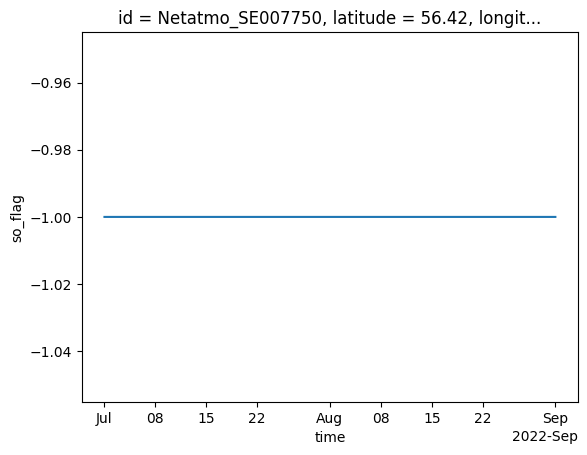

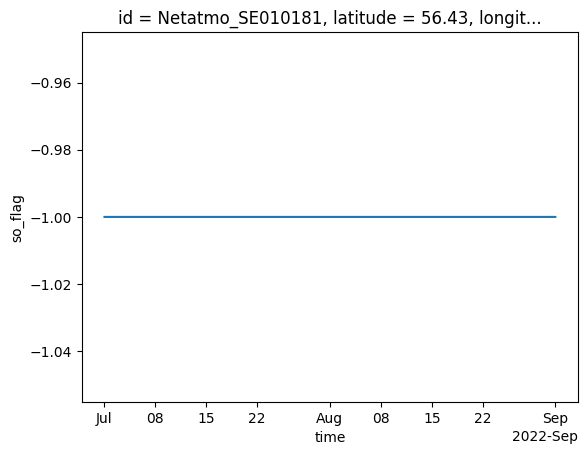

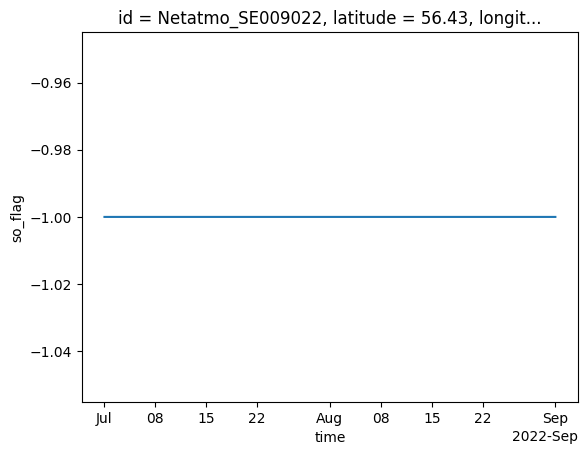

In [24]:
for i in range(3):
    plt.figure()
    ds_pws.so_flag.isel(id = i).plot()

## Cell below: variable and fixed evaluation period. I stopped the script after 4 hours, then it was still working on the first station.

In [14]:
%%time

for i, station_id in enumerate(ds_pws.id.data):  # enumerate(["ams1", "ams45", "ams17"]):
    print(station_id)
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc
    
    # picking stations within range, excluding itself
    nbrs_within_range = (distance_matrix.sel(id=station_id) < max_distance) & (
        distance_matrix.sel(id=station_id) > 0
    )

    # pick neighbors ids, drop all NanNs
    neighbors = (
        distance_matrix.sel(id=station_id)
        .where(nbrs_within_range, drop=True)
        .id_neighbor
    )

    # if there are not enough stations nearby, or no observations in the time series, all timesteps get flagged as -1
    if (len(neighbors.id_neighbor) < n_stat) or (
        ds_pws.rainfall.sel(id=station_id).isnull().all()
    ):
        so_flag[i, :] = -1

    else:
        for j, timestep in enumerate(
            ds_pws.time.isel(time=slice(mint, -1)).data, start=mint
        ):
            #print(timestep)
            #filter not applied in warmup period
            #if j < mint: ???
                #so_flag[i, j] = -1
                #biascorrectiontable[i,j] = BCF_prev

            # fixed evaluation period if at least mrain rainy timesteps in the last mint timesteps
            if (
                cum_rainy_timesteps.sel(id=station_id, time=timestep)
                - cum_rainy_timesteps.sel(id=station_id).isel(time=j - mint + 1)
                >= mrain
            ):
                #print('fixed period')
                evaluation_period_start = j - mint +1
                evaluation_period_end = j

            # variable evaluation period if less than mrain rainy timesteps in the last mint timesteps (but before the considered period starts)
            elif (cum_rainy_timesteps.sel(id=station_id).isel(time=j).data - mrain) > 0:
                start_timestamp = (
                    cum_rainy_timesteps.sel(id=station_id)
                    .where(
                        cum_rainy_timesteps.sel(id=station_id).data
                        == (
                            cum_rainy_timesteps.sel(id=station_id).isel(time=j).data
                            - mrain
                        )
                    )
                    .dropna(dim="time")
                    .time.data
                )
                #print('variable period')
                #print(j)
                start_timestamp = start_timestamp[-1]

                evaluation_period_start = int(
                    ds_pws.number.sel(id=station_id)
                    .where(
                        ds_pws.number.sel(id=station_id).time.data == start_timestamp
                    )
                    .dropna(dim="time")
                    .data.item()
                )
                evaluation_period_end = j

            else:  
                # assign -1 to SO filter, we are in the 'warm up period' of the filter
                so_flag[i, j] = -1
                biascorrectiontable[i,j] = BCF_prev
                continue

            # number of rainy timesteps within evaulation period from neighbors
            matches = (
                rainy_timesteps.sel(id=neighbors)
                .isel(time=slice(evaluation_period_start, evaluation_period_end))
                .sum()
                .data
            )

            if matches < mmatch:
            #filter cannot be applied if less than mmatch overlapping time intvervals
                so_flag[i, timestep] = -1

            else:
                # suppress runtime warning
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)

                    corr_values = np.zeros_like(neighbors, dtype=float)
                    bias_values = np.zeros_like(neighbors, dtype=float)

                    # loop over neighbors
                    for k, neighbor_id in enumerate(neighbors.id_neighbor.data):
                        
                        # pearson correlation with neighboring stations
                        corr = xr.corr(
                            ds_pws.rainfall.sel(id=station_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            ),
                            ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            ),
                        )
                        corr_values[k] = corr.data  

                        # rain_pws - rain_reference (can be for example neighboring stations or radar)
                        delta_r = ds_pws.rainfall.sel(id=station_id).isel(
                            time=slice(evaluation_period_start, evaluation_period_end)
                        ) - ds_pws.rainfall.sel(id=neighbor_id).isel(
                            time=slice(evaluation_period_start, evaluation_period_end)
                        )

                        bias = np.nanmean(delta_r) / np.nanmean(
                            ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            )
                        )
                        bias_values[k] = bias
                        
                        median_correlation = np.median(corr_values)
                        
                        # if median correlation is above threshold gamma,
                        # calculate new bias correction factor
                        if median_correlation > gamma:
                            bias_values[np.isinf(bias_values)] = np.nan
                            median_bias = np.nanmedian(
                                bias_values
                            )  # median of bias of indivial bias to all neigbors
                            BCFnew = 1 / (1 + median_bias)
                            if np.abs(np.log(BCFnew / BCF_prev)) > np.log(1 + beta):
                                BCF_prev = BCFnew
                                biascorrectiontable[i,j] = BCF_new

                        # if the median of the pearson correlation with the neighbors is too low, 
                        # it is a "station outlier"
                        else:
                            so_flag[i, j] = 1
                            biascorrectiontable[i,j] = BCF_prev
    so_flag.to_pickle('C:/Users/a002461/OPENSENSE/data/'+station_id+'.pkl')        


ams1


KeyboardInterrupt: 

In [ ]:
test = so_flag[i, :]
test

In [ ]:
x = range(len(test)) #219168

In [ ]:
plt.figure()
plt.plot(x, test)

In [ ]:
# add flags to dataset
ds_pws["so_flag"] = (("id", "time"), so_flag)
ds_pws["bias"] = (("id", "time"), biascorrectiontable)

In [ ]:
ds_pws.to_netcdf('C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_example_format_data_SO_flags.nc')